# Project 5

#### 1.1

In [41]:
import json

# Hashtag names
hashtag_names = ['tweets_#gohawks.txt', 'tweets_#gopatriots.txt', 'tweets_#nfl.txt',
                'tweets_#patriots.txt', 'tweets_#sb49.txt', 'tweets_#superbowl.txt']

for hashtag_file in hashtag_names:
    
    # Record
    first_time_flag = True
    first_time = 0
    last_time = 0
    tweet_num = 0
    retweet_num = 0
    followers_num = 0
    
    # Open file
    with open(hashtag_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            # Record time of first tweet
            if first_time_flag == True:
                first_time = tweet['citation_date']
                last_time = tweet['citation_date']
                first_time_flag = False
            
            tweet_num += 1
            retweet_num += tweet['metrics']['citations']['total']
            followers_num += tweet['author']['followers']
            
            # Update first and last time
            first_time = min(first_time, tweet['citation_date'])
            last_time = max(last_time, tweet['citation_date'])
        
        # Close the file
        f.close()
    
    # Results
    hour_num = (last_time - first_time) / 3600.0
    avg_tweet_num = tweet_num / hour_num
    avg_retweet_num = retweet_num / tweet_num
    avg_followers_num = followers_num / tweet_num
    
    # Print results
    print('-' * 60)
    print('Hashtag: ', hashtag_file)
    print('Average number of tweets per hour: ', avg_tweet_num)
    print('Average number of followers of users posting the tweets: ', avg_followers_num)
    print('Average number of retweets: ', avg_retweet_num)

------------------------------------------------------------
Hashtag:  tweets_#gohawks.txt
Average number of tweets per hour:  325.37159130433116
Average number of followers of users posting the tweets:  2203.931767444827
Average number of retweets:  2.014617085512608
------------------------------------------------------------
Hashtag:  tweets_#gopatriots.txt
Average number of tweets per hour:  45.69451057356203
Average number of followers of users posting the tweets:  1401.8955093016164
Average number of retweets:  1.4000838670326319
------------------------------------------------------------
Hashtag:  tweets_#nfl.txt
Average number of tweets per hour:  441.3234311373958
Average number of followers of users posting the tweets:  4653.252285502502
Average number of retweets:  1.5385331089011056
------------------------------------------------------------
Hashtag:  tweets_#patriots.txt
Average number of tweets per hour:  834.5555091641886
Average number of followers of users posting th

In [1]:
import json
import datetime, time
import pytz
import numpy as np

# Set time zone
pst_tz = pytz.timezone('US/Pacific')

# Hashtag names
hashtag_names = ['tweets_#gohawks.txt', 'tweets_#gopatriots.txt', 'tweets_#nfl.txt',
                'tweets_#patriots.txt', 'tweets_#sb49.txt', 'tweets_#superbowl.txt']

# Store all the data
dict_all_data = {}

for hashtag_file in hashtag_names:
    
    # Find min_time and max_time
    all_times = []
    with open(hashtag_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            all_times.append(tweet['citation_date'])
        
        # Close the file
        f.close()
    
    min_time = min(all_times)
    max_time = max(all_times)
    
    # Get start and end timestamp
    start_time = datetime.datetime.fromtimestamp(min_time, pst_tz)
    end_time = datetime.datetime.fromtimestamp(max_time, pst_tz)
    # Truncate time to hour precision
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    end_time = end_time.replace(minute=0, second=0, microsecond=0)
    
    # Total number of hours
    total_hours = (end_time - start_time).days * 24 + (end_time - start_time).seconds // 3600
    
    # Build a numpy array to store the features
    feature_shape = (total_hours + 1, 5)
    all_data = np.zeros(feature_shape)
    
    # Initialize hour of the day
    all_data[0][4] = start_time.time().hour
    for i in range(1, total_hours + 1):
        all_data[i][4] = (all_data[i - 1][4] + 1) % 24
    
    # Open file
    with open(hashtag_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            
            # Get current time
            current_time = datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz)
            # Truncate time to hour precision
            current_time = current_time.replace(minute=0, second=0, microsecond=0)
            # Find hour number
            hour_num = (current_time - start_time).days * 24 + (current_time - start_time).seconds // 3600
            # Number of tweets
            all_data[hour_num][0] += 1
            # Number of retweets
            all_data[hour_num][1] += tweet['metrics']['citations']['total']
            # Number of followers
            all_data[hour_num][2] += tweet['author']['followers']
            # Max number of the followers
            all_data[hour_num][3] = max(all_data[hour_num][3], tweet['author']['followers'])
        
        # Close the file
        f.close()
    
    # Results
    dict_all_data[hashtag_file] = all_data

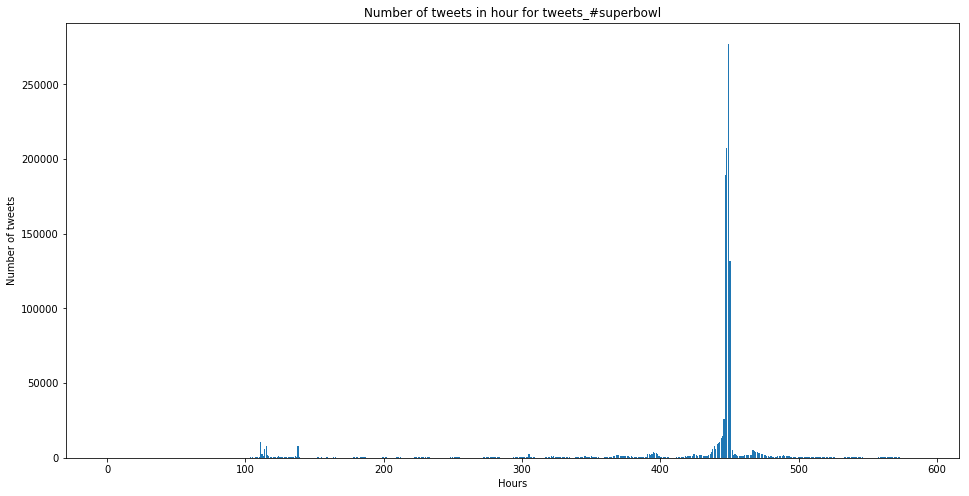

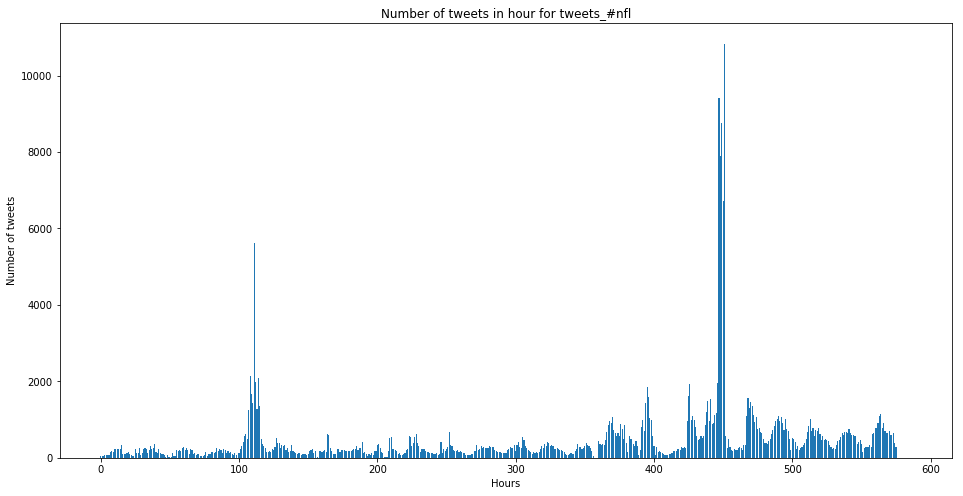

In [3]:
import numpy as np
import matplotlib.pyplot as plt

# For #SuperBowl and #NFL
target_hashtags = ['tweets_#superbowl.txt', 'tweets_#nfl.txt']

for hashtag in target_hashtags:
    
    # Plot
    plt.figure(figsize=(16, 8))
    hist = dict_all_data[hashtag][:, 0] # Number of tweets
    plt.bar(range(len(hist)), hist)
    hashtag_name = hashtag.split('.')[0]
    plt.title(('Number of tweets in hour for ' + hashtag_name))
    plt.xlabel('Hours')
    plt.ylabel('Number of tweets')
    plt.savefig('Figures/q1_1_' + hashtag_name + '.png', format='png')
    plt.show()

#### 1.2

In [4]:
import statsmodels.api as sm
from sklearn import metrics
import numpy as np

for k, v in dict_all_data.items():
    print('-' * 60)
    print('Hashtag: ', k)
    
    # Ignore the last hour
    x_train = v[:-1, :]
    # Shift y_label
    y_true = v[1:, 0]
    
    # Predict
    model = sm.OLS(y_true, x_train).fit()
    y_pred = model.predict()

    print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('Summary report: ')
    print(model.summary())
    print('\n')

f:\python3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


------------------------------------------------------------
Hashtag:  tweets_#gohawks.txt
RMSE:  974.084617763
Summary report: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.501
Model:                            OLS   Adj. R-squared:                  0.496
Method:                 Least Squares   F-statistic:                     114.8
Date:                Sat, 10 Mar 2018   Prob (F-statistic):           5.45e-84
Time:                        13:32:34   Log-Likelihood:                -4797.7
No. Observations:                 578   AIC:                             9605.
Df Residuals:                     573   BIC:                             9627.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

#### 1.3

In [1]:
import json
import datetime, time
import pytz
import numpy as np
from collections import defaultdict

# Set time zone
pst_tz = pytz.timezone('US/Pacific')

# Hashtag names
hashtag_names = ['tweets_#gohawks.txt', 'tweets_#gopatriots.txt', 'tweets_#nfl.txt',
                'tweets_#patriots.txt', 'tweets_#sb49.txt', 'tweets_#superbowl.txt']

# Store all the data
dict_all_data = {}

# Feature sequence
feature_names = ['Number of tweets', 'Total number of retweets', 'Sum of the number of followers', 
                'Maximum number of followers', 'Time of the day', 'Total number of impressions',
                'Total number of momentum', 'Total number of favorite count', 'Total number of ranking score',
                'Total number of acceleration', 'Total number of replies', 'Total number of unique users',
                'Total number of unique authors', 'Total number of user mentions']

# Number of features
total_feature_num = len(feature_names)

# Print features
print('Total number of features: ', total_feature_num)
print('Features: ')
print(feature_names)

for hashtag_file in hashtag_names:
    
    # Find min_time and max_time
    all_times = []
    with open(hashtag_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            all_times.append(tweet['citation_date'])
        
        # Close the file
        f.close()
    
    min_time = min(all_times)
    max_time = max(all_times)
    
    # Get start and end timestamp
    start_time = datetime.datetime.fromtimestamp(min_time, pst_tz)
    end_time = datetime.datetime.fromtimestamp(max_time, pst_tz)
    # Truncate time to hour precision
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    end_time = end_time.replace(minute=0, second=0, microsecond=0)
    
    # Total number of hours
    total_hours = (end_time - start_time).days * 24 + (end_time - start_time).seconds // 3600
    
    # Build a numpy array to store the features
    feature_shape = (total_hours + 1, total_feature_num)
    all_data = np.zeros(feature_shape)
    
    # Initialize hour of the day
    all_data[0][4] = start_time.time().hour
    for i in range(1, total_hours + 1):
        all_data[i][4] = (all_data[i - 1][4] + 1) % 24
    
    # Unique set
    dict_unique_users = defaultdict(set)
    dict_unique_authors = defaultdict(set)
    
    # Open file
    with open(hashtag_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            
            # Get current time
            current_time = datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz)
            # Truncate time to hour precision
            current_time = current_time.replace(minute=0, second=0, microsecond=0)
            # Find hour number
            hour_num = (current_time - start_time).days * 24 + (current_time - start_time).seconds // 3600
            # Number of tweets
            all_data[hour_num][0] += 1
            # Number of retweets
            all_data[hour_num][1] += tweet['metrics']['citations']['total']
            # Number of followers
            all_data[hour_num][2] += tweet['author']['followers']
            # Max number of the followers
            all_data[hour_num][3] = max(all_data[hour_num][3], tweet['author']['followers'])
            # New features
            all_data[hour_num][5] += tweet['metrics']['impressions']
            all_data[hour_num][6] += tweet['metrics']['momentum']
            all_data[hour_num][7] += tweet['tweet']['favorite_count']
            all_data[hour_num][8] += tweet['metrics']['ranking_score']
            all_data[hour_num][9] += tweet['metrics']['acceleration']
            all_data[hour_num][10] += tweet['metrics']['citations']['replies']
            if tweet['tweet']['user']['id'] not in dict_unique_users[hour_num]:
                dict_unique_users[hour_num].add(tweet['tweet']['user']['id'])
                all_data[hour_num][11] += 1
            if tweet['author']['name'] not in dict_unique_authors[hour_num]:
                dict_unique_authors[hour_num].add(tweet['author']['name'])
                all_data[hour_num][12] += 1
            all_data[hour_num][13] += len(tweet['tweet']['entities']['user_mentions'])
        
        # Close the file
        f.close()
    
    # Results
    dict_all_data[hashtag_file] = all_data

Total number of features:  14
Features: 
['Number of tweets', 'Total number of retweets', 'Sum of the number of followers', 'Maximum number of followers', 'Time of the day', 'Total number of impressions', 'Total number of momentum', 'Total number of favorite count', 'Total number of ranking score', 'Total number of acceleration', 'Total number of replies', 'Total number of unique users', 'Total number of unique authors', 'Total number of user mentions']


In [16]:
import statsmodels.api as sm
from sklearn import metrics
import numpy as np

for k, v in dict_all_data.items():
    print('-' * 60)
    print('Hashtag: ', k)
    
    # Ignore the last hour
    x_train = v[:-1, :]
    # Shift y_label
    y_true = v[1:, 0]
    
    # Predict
    model = sm.OLS(y_true, x_train).fit()
    y_pred = model.predict()

    print('RMSE: ', np.sqrt(metrics.mean_squared_error(y_true, y_pred)))
    print('Summary report: ')
    print(model.summary())
    print('\n')

f:\python3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


------------------------------------------------------------
Hashtag:  tweets_#gohawks.txt
RMSE:  672.584552561
Summary report: 
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.762
Model:                            OLS   Adj. R-squared:                  0.756
Method:                 Least Squares   F-statistic:                     128.9
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          2.68e-165
Time:                        13:56:37   Log-Likelihood:                -4583.6
No. Observations:                 578   AIC:                             9195.
Df Residuals:                     564   BIC:                             9256.
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
--

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.899
Model:                            OLS   Adj. R-squared:                  0.897
Method:                 Least Squares   F-statistic:                     361.8
Date:                Mon, 12 Mar 2018   Prob (F-statistic):          4.29e-272
Time:                        13:56:37   Log-Likelihood:                -5531.2
No. Observations:                 582   AIC:                         1.109e+04
Df Residuals:                     568   BIC:                         1.115e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -31.5130      5.462     -5.769      0.0

------------------------------------------------------------
Hashtag:  tweets_#gohawks.txt
Important features: 
['Number of tweets', 'Total number of ranking score', 'Total number of unique authors']


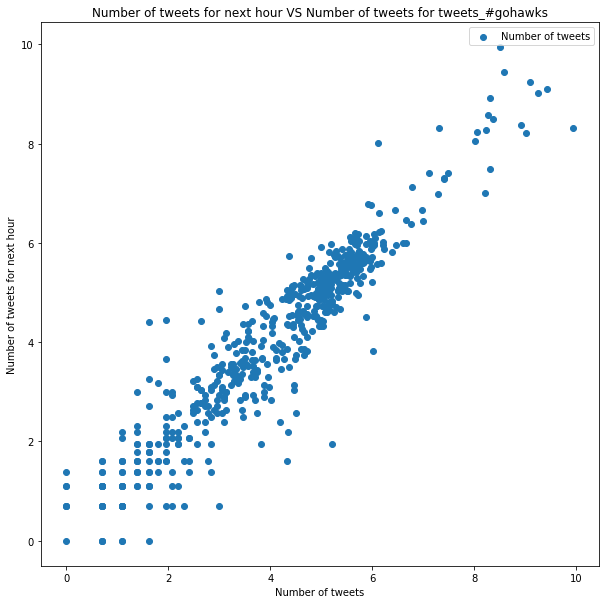

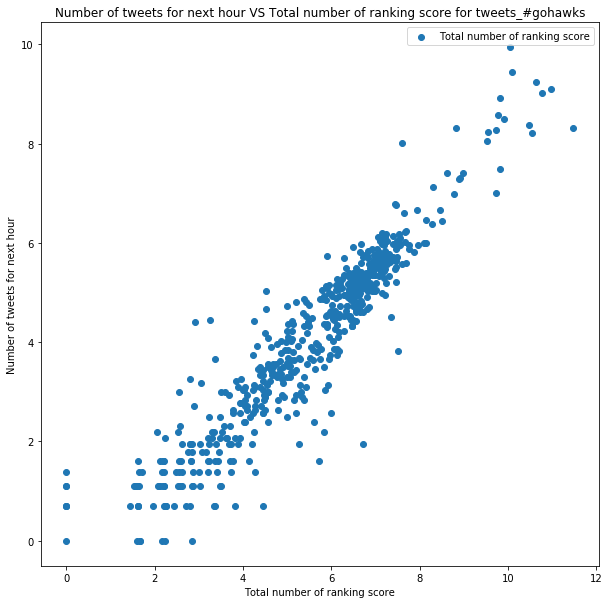

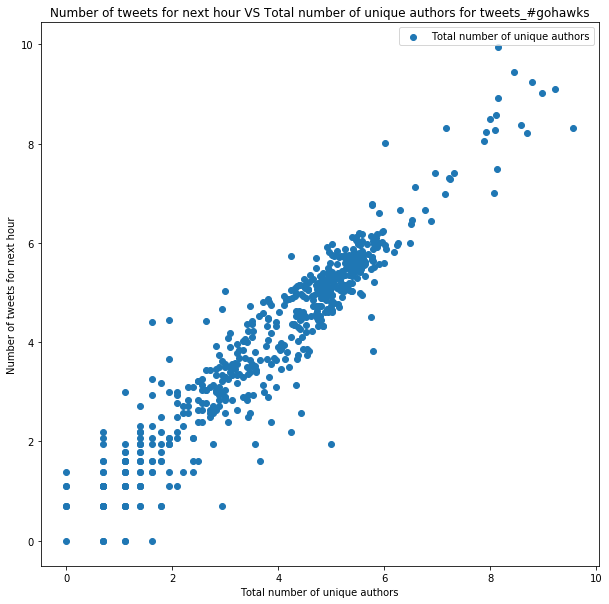

------------------------------------------------------------
Hashtag:  tweets_#gopatriots.txt
Important features: 
['Total number of retweets', 'Total number of ranking score', 'Total number of user mentions']


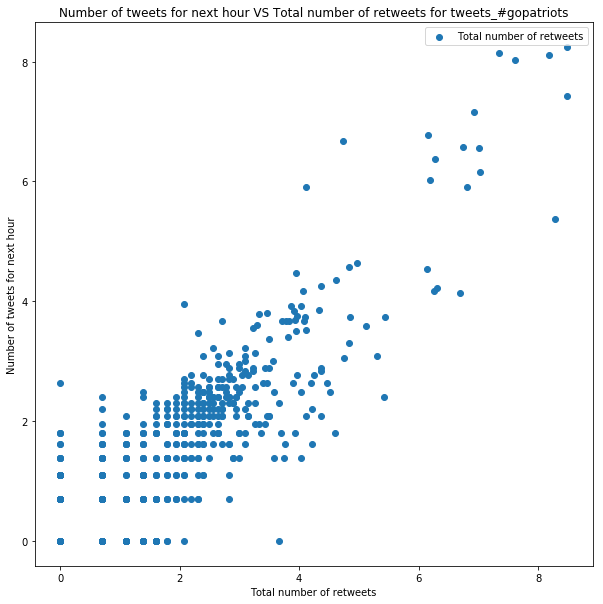

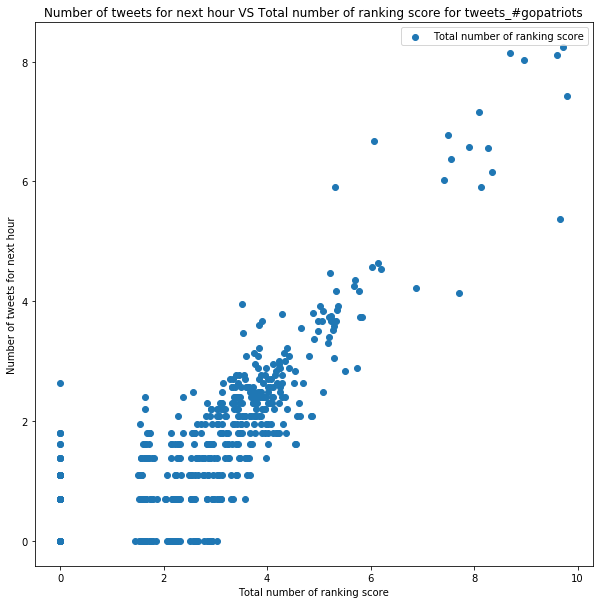

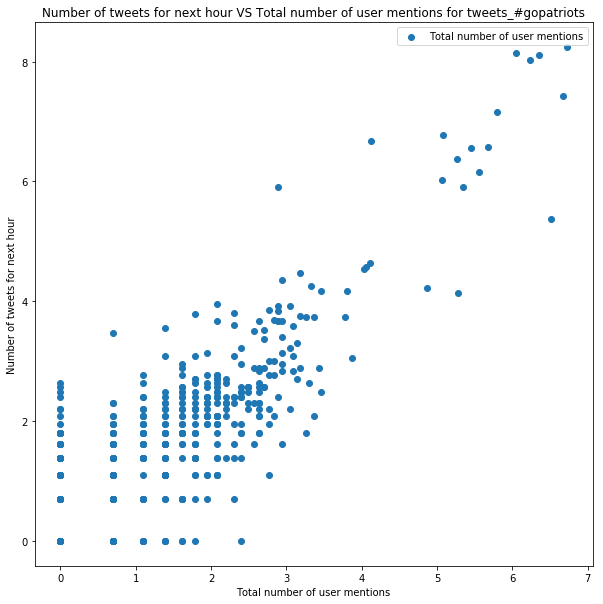

------------------------------------------------------------
Hashtag:  tweets_#nfl.txt
Important features: 
['Maximum number of followers', 'Total number of unique users', 'Total number of user mentions']


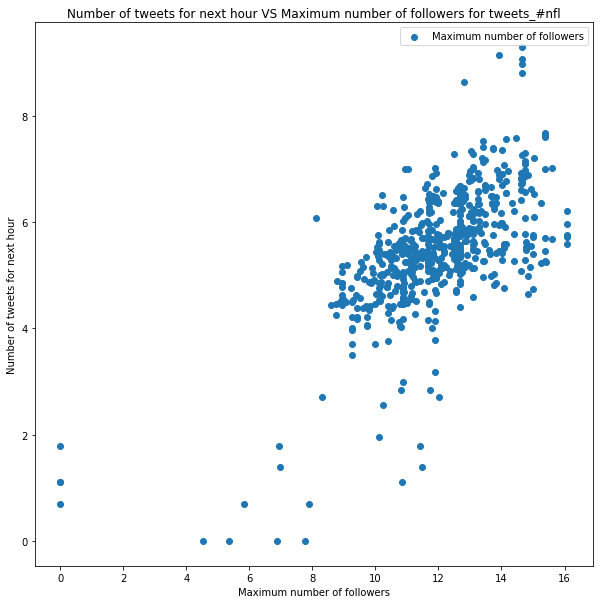

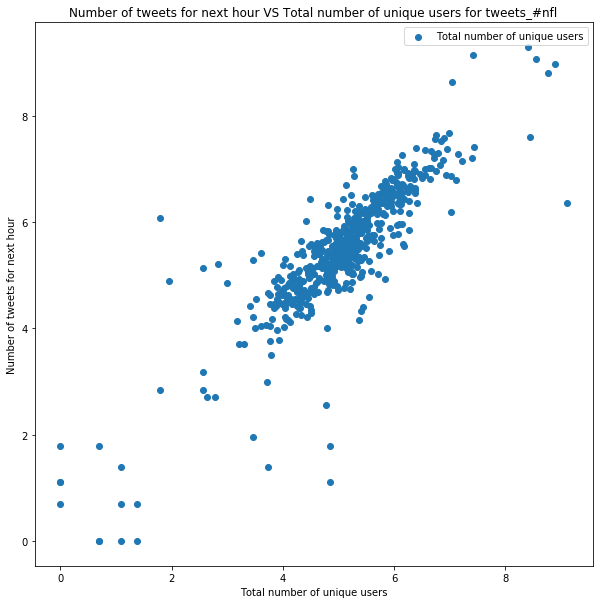

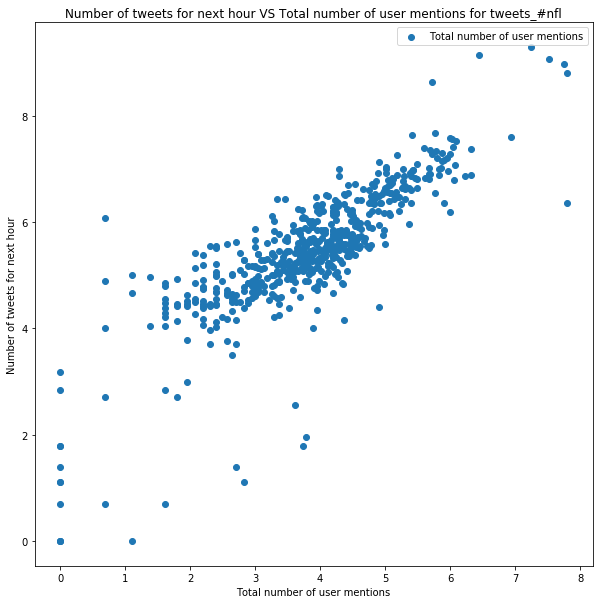

------------------------------------------------------------
Hashtag:  tweets_#patriots.txt
Important features: 
['Number of tweets', 'Total number of unique users', 'Total number of ranking score']


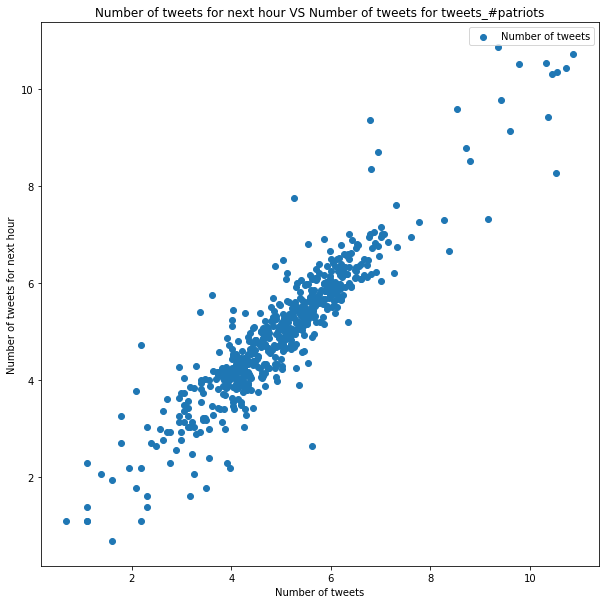

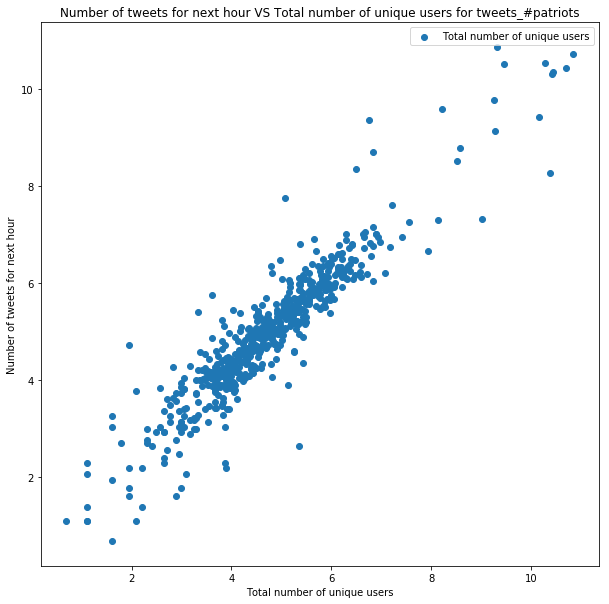

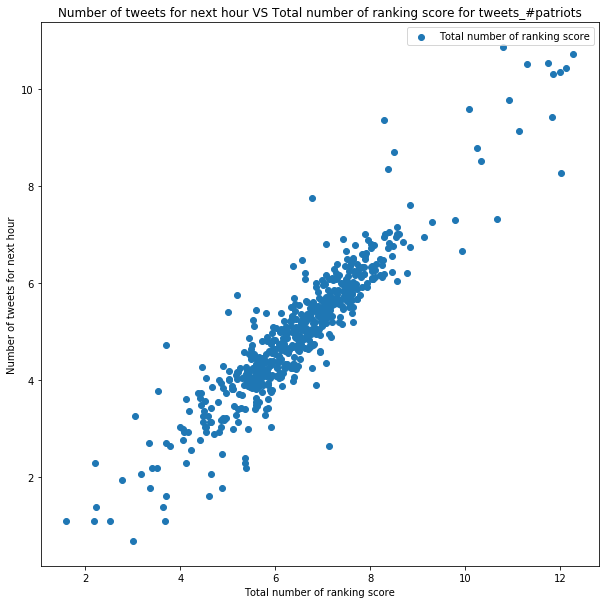

------------------------------------------------------------
Hashtag:  tweets_#sb49.txt
Important features: 
['Number of tweets', 'Total number of unique users', 'Total number of ranking score']


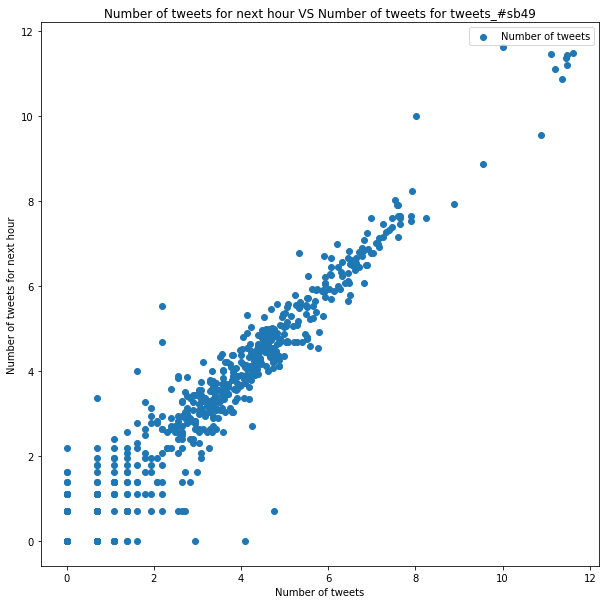

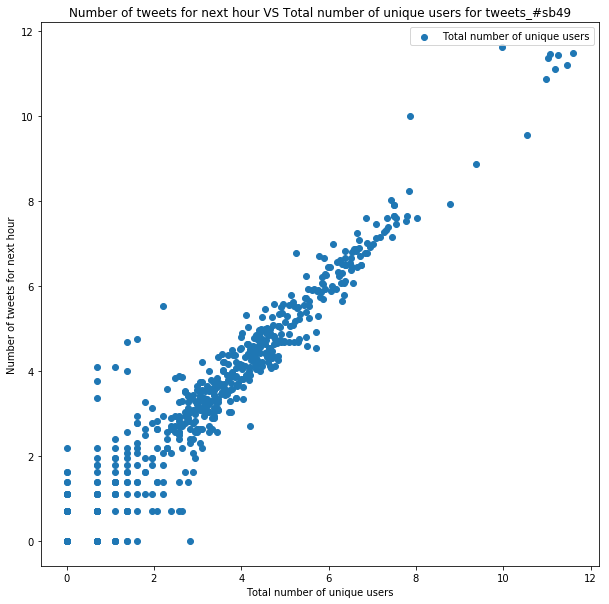

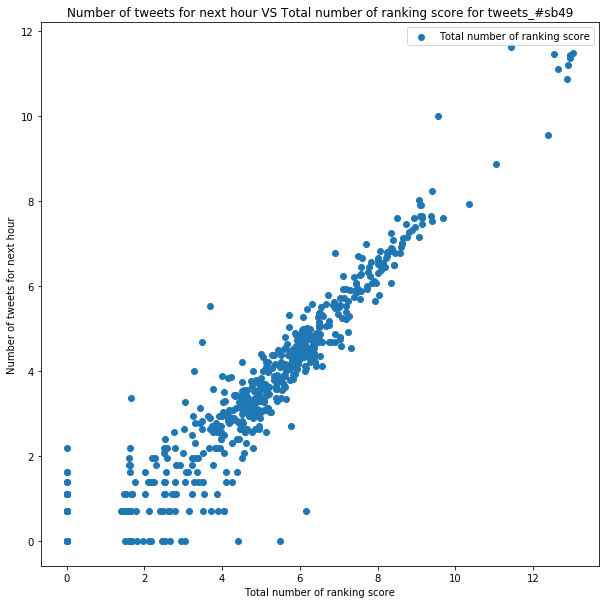

------------------------------------------------------------
Hashtag:  tweets_#superbowl.txt
Important features: 
['Total number of unique authors', 'Total number of retweets', 'Total number of unique users']


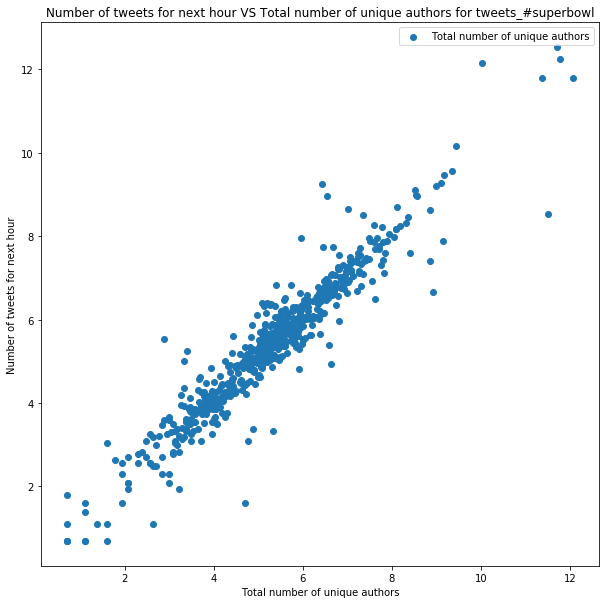

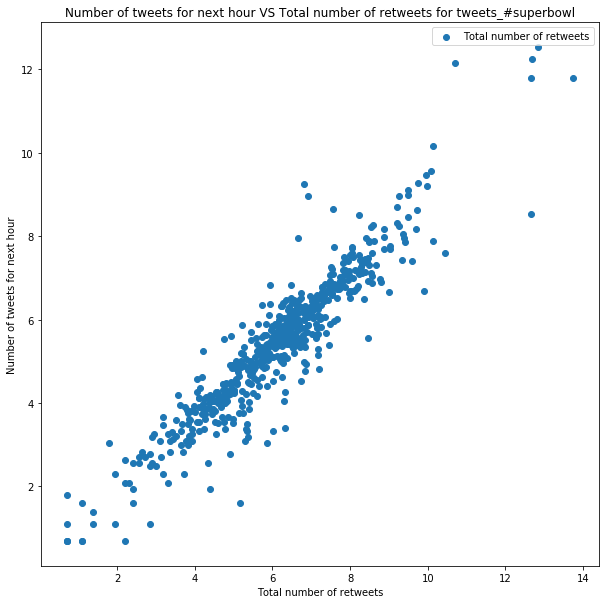

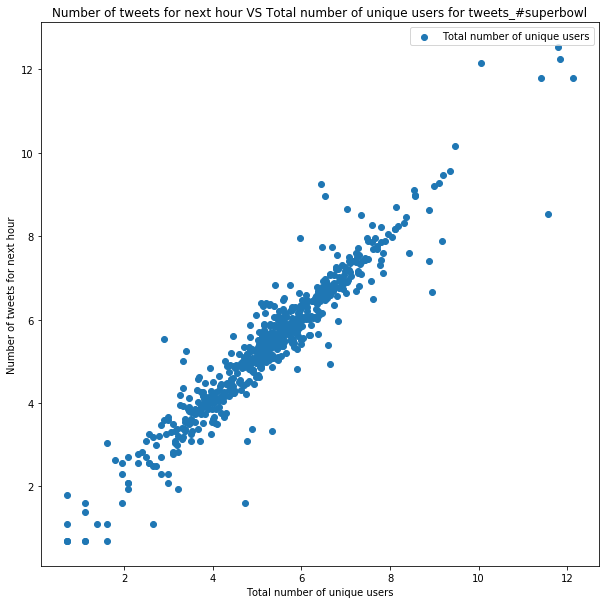

In [30]:
import matplotlib.pyplot as plt

# Most important features
dict_important_feature_indices = {'tweets_#gohawks.txt': [0, 8, 12],
                                  'tweets_#gopatriots.txt': [1, 8, 13],
                                  'tweets_#nfl.txt': [3, 11, 13],
                                  'tweets_#patriots.txt': [0, 11, 8],
                                  'tweets_#sb49.txt': [0, 11, 8],
                                  'tweets_#superbowl.txt': [12, 1, 11]}

for k in dict_important_feature_indices.keys():
    print('-' * 60)
    print('Hashtag: ', k)
    print('Important features: ')
    important_feature_indices = dict_important_feature_indices[k]
    print([feature_names[i] for i in important_feature_indices])
    
    # Data
    x_train = dict_all_data[k][:-1, :]
    y_true = dict_all_data[k][1:, 0]
    
    # Plot
    for feature_index in important_feature_indices:
        plt.figure(figsize=(10, 10))
        hashtag_name = k.split('.')[0]
        important_feature_name = feature_names[feature_index]
        plt.title(('Number of tweets for next hour VS ' + important_feature_name + ' for ' + hashtag_name))
        plt.xlabel(important_feature_name)
        plt.ylabel('Number of tweets for next hour')
        
        # Use the log transformation
        x_values = np.log1p(x_train[:, feature_index])
        y_values = np.log1p(y_true)
        plt.scatter(x_values, y_values, label=important_feature_name)
        plt.legend()
        plt.savefig('Figures/q1_3_' + hashtag_name + '_' + important_feature_name + '.png', format='png')
        plt.show()

#### 1.4

In [2]:
# Hashtag names
hashtag_names = ['tweets_#gohawks.txt', 'tweets_#gopatriots.txt', 'tweets_#nfl.txt',
                'tweets_#patriots.txt', 'tweets_#sb49.txt', 'tweets_#superbowl.txt']

# Record all start and end times
all_start_times = {}
all_end_times = {}

for hashtag_file in hashtag_names:
    
    # Get the start time of each hashtag
    all_times = []
    with open(hashtag_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            all_times.append(tweet['citation_date'])
        
        # Close the file
        f.close()
    
    min_time = min(all_times)
    max_time = max(all_times)
    all_start_times[hashtag_file] = min_time
    all_end_times[hashtag_file] = max_time

In [3]:
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn import metrics

# Two timestamps required
time1 = datetime.datetime.strptime('Feb-01-2015 08:00:00', '%b-%d-%Y %H:%M:%S')
time2 = datetime.datetime.strptime('Feb-01-2015 20:00:00', '%b-%d-%Y %H:%M:%S')

for hashtag_file in hashtag_names:
    
    min_time = all_start_times[hashtag_file]
    
    # Get start and end timestamp
    start_time = datetime.datetime.fromtimestamp(min_time, pst_tz)
    # Truncate time to hour precision
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    start_time = start_time.replace(tzinfo=None)
    
    # Hour number of time1 and time2
    hour_num1 = (time1 - start_time).days * 24 + (time1 - start_time).seconds // 3600
    hour_num2 = (time2 - start_time).days * 24 + (time2 - start_time).seconds // 3600
    
    # All data
    x_train_all = dict_all_data[hashtag_file][:-1, :]
    y_true_all = dict_all_data[hashtag_file][1:, 0]
    
    # Three time periods
    dict_x_train = {}
    dict_y_true = {}
    
    dict_x_train['Before Feb. 1, 8:00 a.m.'] = x_train_all[0:hour_num1, :]
    dict_x_train['Between Feb. 1, 8:00 a.m. and 8:00 p.m.'] = x_train_all[hour_num1:hour_num2, :]
    dict_x_train['After Feb. 1, 8:00 p.m.'] = x_train_all[hour_num2:, :]
    
    dict_y_true['Before Feb. 1, 8:00 a.m.'] = y_true_all[0:hour_num1]
    dict_y_true['Between Feb. 1, 8:00 a.m. and 8:00 p.m.'] = y_true_all[hour_num1:hour_num2]
    dict_y_true['After Feb. 1, 8:00 p.m.'] = y_true_all[hour_num2:]
    
    print('-' * 60)
    print('Hashtag: ', hashtag_file)
    print('-' * 60)
    
    for time_period in dict_x_train.keys():
        print('-' * 30)
        print('Time period: ', time_period)
        print('-' * 30)
        
        # CV
        dict_y_predict_period = {}
        
        x_train_period = dict_x_train[time_period]
        y_true_period = dict_y_true[time_period]
        
        print('Number of hours in this period: ', y_true_period.shape[0])
        
        # Linear model
        model1 = LinearRegression()
        dict_y_predict_period['Linear Regression'] = cross_val_predict(model1, x_train_period, y_true_period, cv=10)
        
        # SVM model
        model2 = SVR()
        dict_y_predict_period['SVM Regression'] = cross_val_predict(model2, x_train_period, y_true_period, cv=10)
        
        # RandomForestRegressor model
        model3 = RandomForestRegressor(n_estimators=100)  # Use more trees for stable results
        dict_y_predict_period['Random Forest Regression'] = cross_val_predict(model3, x_train_period, y_true_period, cv=10)
        
        # GradientBoostingRegressor model
        #model4 = GradientBoostingRegressor()
        #dict_y_predict_period['Gradient Boosting'] = cross_val_predict(model4, x_train_period, y_true_period, cv=10)
        # Result without CV
        #model4 = sm.OLS(y_true_period, x_train_period).fit()
        #dict_y_predict_period['OLS'] = model4.predict()
        
        for model_name, predict_value in dict_y_predict_period.items():
            print(model_name)
            abs_error = np.mean(np.absolute(y_true_period - predict_value))
            print('Validation mean absolute error: ', abs_error)
            
            RMSE = np.sqrt(metrics.mean_squared_error(y_true_period, predict_value))
            print('Validation RMSE: ', RMSE)

------------------------------------------------------------
Hashtag:  tweets_#gohawks.txt
------------------------------------------------------------
------------------------------
Time period:  Before Feb. 1, 8:00 a.m.
------------------------------
Number of hours in this period:  440
Linear Regression
Validation mean absolute error:  298.250292112
Validation RMSE:  1030.69840366
SVM Regression
Validation mean absolute error:  224.807121212
Validation RMSE:  1140.98987637
Random Forest Regression
Validation mean absolute error:  159.763159091
Validation RMSE:  1098.33721526
------------------------------
Time period:  Between Feb. 1, 8:00 a.m. and 8:00 p.m.
------------------------------
Number of hours in this period:  12
Linear Regression
Validation mean absolute error:  5084.98598697
Validation RMSE:  8918.41019784
SVM Regression
Validation mean absolute error:  3158.75
Validation RMSE:  4083.77110238
Random Forest Regression
Validation mean absolute error:  2157.33
Validation R

Linear Regression
Validation mean absolute error:  406.452285507
Validation RMSE:  1460.64574057
SVM Regression
Validation mean absolute error:  606.205970149
Validation RMSE:  1035.57347489
Random Forest Regression
Validation mean absolute error:  284.475597015
Validation RMSE:  602.485406493


In [4]:
from collections import defaultdict

dict_x_train_all_hashtag = defaultdict(list)
dict_y_true_all_hashtag = defaultdict(list)

for hashtag_file in hashtag_names:
    
    min_time = all_start_times[hashtag_file]
    
    # Get start and end timestamp
    start_time = datetime.datetime.fromtimestamp(min_time, pst_tz)
    # Truncate time to hour precision
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    start_time = start_time.replace(tzinfo=None)
    
    # Hour number of time1 and time2
    hour_num1 = (time1 - start_time).days * 24 + (time1 - start_time).seconds // 3600
    hour_num2 = (time2 - start_time).days * 24 + (time2 - start_time).seconds // 3600
    
    # All data
    x_train_all = dict_all_data[hashtag_file][:-1, :]
    y_true_all = dict_all_data[hashtag_file][1:, 0]
    
    # Three time periods
    dict_x_train_all_hashtag['Before Feb. 1, 8:00 a.m.'].append(x_train_all[0:hour_num1, :])
    dict_x_train_all_hashtag['Between Feb. 1, 8:00 a.m. and 8:00 p.m.'].append(x_train_all[hour_num1:hour_num2, :])
    dict_x_train_all_hashtag['After Feb. 1, 8:00 p.m.'].append(x_train_all[hour_num2:, :])
    
    dict_y_true_all_hashtag['Before Feb. 1, 8:00 a.m.'].append(y_true_all[0:hour_num1])
    dict_y_true_all_hashtag['Between Feb. 1, 8:00 a.m. and 8:00 p.m.'].append(y_true_all[hour_num1:hour_num2])
    dict_y_true_all_hashtag['After Feb. 1, 8:00 p.m.'].append(y_true_all[hour_num2:])

dict_x_train_aggregate_period = {}
dict_y_true_aggregate_period = {}

for k in dict_x_train_all_hashtag.keys():
    dict_x_train_aggregate_period[k] = np.concatenate(dict_x_train_all_hashtag[k], axis=0)
    dict_y_true_aggregate_period[k] = np.concatenate(dict_y_true_all_hashtag[k])

print('Best model: Random Forest Regressor')

for time_period in dict_x_train_aggregate_period.keys():
    print('-' * 60)
    print('Time period: ', time_period)
    
    # RandomForestRegressor model
    best_model = RandomForestRegressor(n_estimators=100)  # Use more trees for stable results
    
    x_train_period = dict_x_train_aggregate_period[k]
    y_true_period = dict_y_true_aggregate_period[k]
    best_model.fit(x_train_period, y_true_period)
    
    y_predict_period = best_model.predict(x_train_period)
    
    RMSE = np.sqrt(metrics.mean_squared_error(y_true_period, y_predict_period))
    print('Train RMSE: ', RMSE)
    
    abs_error = np.mean(np.absolute(y_true_period - y_predict_period))
    print('Train mean absolute error: ', abs_error)

Best model: Random Forest Regressor
------------------------------------------------------------
Time period:  Before Feb. 1, 8:00 a.m.
Train RMSE:  83.4185978459
Train mean absolute error:  28.8931528165
------------------------------------------------------------
Time period:  Between Feb. 1, 8:00 a.m. and 8:00 p.m.
Train RMSE:  82.4672430111
Train mean absolute error:  29.1761430664
------------------------------------------------------------
Time period:  After Feb. 1, 8:00 p.m.
Train RMSE:  86.107902935
Train mean absolute error:  29.5298814152


#### 1.5

In [5]:
# Test file
test_files = ['sample1_period1.txt', 'sample2_period2.txt', 'sample3_period3.txt', 'sample4_period1.txt',
              'sample5_period1.txt', 'sample6_period2.txt', 'sample7_period3.txt', 'sample8_period1.txt',
              'sample9_period2.txt', 'sample10_period3.txt']

dict_all_test_data = {}

for test_file in test_files:
    # Find min_time and max_time
    all_times = []
    with open(test_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            all_times.append(tweet['citation_date'])
        
        # Close the file
        f.close()
    
    min_time = min(all_times)
    max_time = max(all_times)
    
    # Get start and end timestamp
    start_time = datetime.datetime.fromtimestamp(min_time, pst_tz)
    end_time = datetime.datetime.fromtimestamp(max_time, pst_tz)
    # Truncate time to hour precision
    start_time = start_time.replace(minute=0, second=0, microsecond=0)
    end_time = end_time.replace(minute=0, second=0, microsecond=0)
    
    # Total number of hours
    total_hours = (end_time - start_time).days * 24 + (end_time - start_time).seconds // 3600
    
    # Build a numpy array to store the features
    feature_shape = (total_hours + 1, total_feature_num)
    all_data = np.zeros(feature_shape)
    
    # Initialize hour of the day
    all_data[0][4] = start_time.time().hour
    for i in range(1, total_hours + 1):
        all_data[i][4] = (all_data[i - 1][4] + 1) % 24
    
    # Unique set
    dict_unique_users = defaultdict(set)
    dict_unique_authors = defaultdict(set)
    
    # Open file
    with open(test_file) as f:      
        # Read line by line
        for line in f.readlines():          
            # Use json format
            tweet = json.loads(line)
            
            # Get current time
            current_time = datetime.datetime.fromtimestamp(tweet['citation_date'], pst_tz)
            # Truncate time to hour precision
            current_time = current_time.replace(minute=0, second=0, microsecond=0)
            # Find hour number
            hour_num = (current_time - start_time).days * 24 + (current_time - start_time).seconds // 3600
            # Number of tweets
            all_data[hour_num][0] += 1
            # Number of retweets
            all_data[hour_num][1] += tweet['metrics']['citations']['total']
            # Number of followers
            all_data[hour_num][2] += tweet['author']['followers']
            # Max number of the followers
            all_data[hour_num][3] = max(all_data[hour_num][3], tweet['author']['followers'])
            # New features
            all_data[hour_num][5] += tweet['metrics']['impressions']
            all_data[hour_num][6] += tweet['metrics']['momentum']
            all_data[hour_num][7] += tweet['tweet']['favorite_count']
            all_data[hour_num][8] += tweet['metrics']['ranking_score']
            all_data[hour_num][9] += tweet['metrics']['acceleration']
            all_data[hour_num][10] += tweet['metrics']['citations']['replies']
            if tweet['tweet']['user']['id'] not in dict_unique_users[hour_num]:
                dict_unique_users[hour_num].add(tweet['tweet']['user']['id'])
                all_data[hour_num][11] += 1
            if tweet['author']['name'] not in dict_unique_authors[hour_num]:
                dict_unique_authors[hour_num].add(tweet['author']['name'])
                all_data[hour_num][12] += 1
            all_data[hour_num][13] += len(tweet['tweet']['entities']['user_mentions'])
        
        # Close the file
        f.close()
    
    # Results
    dict_all_test_data[test_file] = all_data

In [8]:
from sklearn.ensemble import RandomForestRegressor

# Number of hours used
hour_window_size = 4

dict_x_train_all_hashtag = defaultdict(list)
dict_y_true_all_hashtag = defaultdict(list)

for hashtag_file in hashtag_names:
    
    # All data
    x_train_all = dict_all_data[hashtag_file][:-1, :]
    y_true_all = dict_all_data[hashtag_file][1:, 0]
    
    # Concatenate features for multiple hours
    y_true_window = y_true_all[hour_window_size-1:]
    x_train_window = np.zeros((y_true_window.shape[0], total_feature_num*hour_window_size))
    for i in range(y_true_window.shape[0]):
        x_train_window[i, :] = x_train_all[i:i+hour_window_size, :].reshape(-1, total_feature_num*hour_window_size)
    
    # All data 
    dict_x_train_all_hashtag['All_window'].append(x_train_window)
    dict_y_true_all_hashtag['All_window'].append(y_true_window)

# 1 hour data
x_train_aggregate_window = np.concatenate(dict_x_train_all_hashtag['All_window'], axis=0)
y_true_aggregate_window = np.concatenate(dict_y_true_all_hashtag['All_window'])

# RandomForestRegressor model
best_model = RandomForestRegressor(n_estimators=100)  # Use more trees for stable results
best_model.fit(x_train_aggregate_window, y_true_aggregate_window)

# Test each file
for test_file, test_data in dict_all_test_data.items():
    print('-' * 60)
    print(test_file)
    
    if test_data.shape[0] > hour_window_size:
        
        x_test = test_data[-hour_window_size-1:-1, :].reshape(-1, total_feature_num*hour_window_size)
        y_test_true = test_data[-1][0]
        
        # Predict
        y_test_predict = best_model.predict(x_test)[0]
        
        print('True number of tweets for the last hour: ', y_test_true)
        print('Predicted number of tweets for the last hour: ', y_test_predict)

------------------------------------------------------------
sample1_period1.txt
True number of tweets for the last hour:  1.0
Predicted number of tweets for the last hour:  30.39
------------------------------------------------------------
sample2_period2.txt
True number of tweets for the last hour:  4.0
Predicted number of tweets for the last hour:  14.28
------------------------------------------------------------
sample3_period3.txt
True number of tweets for the last hour:  523.0
Predicted number of tweets for the last hour:  679.62
------------------------------------------------------------
sample4_period1.txt
True number of tweets for the last hour:  201.0
Predicted number of tweets for the last hour:  253.2
------------------------------------------------------------
sample5_period1.txt
True number of tweets for the last hour:  1.0
Predicted number of tweets for the last hour:  0.58
------------------------------------------------------------
sample6_period2.txt
True number of 

#### 2

In [12]:
import json

# Target
target_hashtag = 'tweets_#superbowl.txt'

# ROW text and location
all_row_texts = []
all_locations = []
class0_num = 0
class1_num = 0

# Use the state names and several large cities
class0_locations = ['Seattle','Spokane', 'Tacoma', 'Vancouver', 'Bellevue', 'Kirkland', 'Washington', 'WA', 'Wa']
class1_locations = ['Boston', 'Worcester', 'Springfield', 'Lowell', 'Cambridge', 'Massachusetts', 'MA', 'Ma']

# Get tweets and locations
with open(target_hashtag) as f:
    # Read line by line
    for line in f.readlines():          
        # Use json format
        tweet = json.loads(line)
        current_location = tweet['tweet']['user']['location']
        current_text = tweet['title']
        if any(substring in current_location for substring in class0_locations):
            class0_num += 1
            all_row_texts.append(current_text)
            all_locations.append(0)
        if any(substring in current_location for substring in class1_locations):
            class1_num += 1
            all_row_texts.append(current_text)
            all_locations.append(1)
    
    f.close()            

print('Class 0 size: ', class0_num)
print('Class 1 size: ', class1_num)

Class 0 size:  41695
Class 1 size:  50267


In [13]:
import re
import string
from sklearn.feature_extraction import text
from nltk.stem.snowball import SnowballStemmer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.decomposition import TruncatedSVD

# Stemming
def process_doc(a_doc):
    temp_doc = re.sub('[^a-zA-Z]', ' ', a_doc)
    temp_doc = re.sub('[,.-:/()?{}*$#&]', ' ', temp_doc)  # exclude other symbols
    temp_doc = ''.join([ch for ch in temp_doc if ch not in string.punctuation])  # exclude punctuations
    temp_doc = ''.join(ch for ch in temp_doc if ord(ch) < 128)  # exclude non-ascii characters
    temp_doc = temp_doc.lower()  # use lowercase
    words = temp_doc.split()
    stop_words = text.ENGLISH_STOP_WORDS
    words = [word for word in words if word not in stop_words]  # exclude stop words
    stemmer = SnowballStemmer("english")
    words = [stemmer.stem(word) for word in words]  # stem the words
    temp_doc = ' '.join(words)
    return temp_doc

all_texts_stemmed = []

for doc in all_row_texts:
    all_texts_stemmed.append(process_doc(doc))
    
# Split test and train set
texts_train, texts_test, locs_train, locs_test = train_test_split(all_texts_stemmed, all_locations, test_size=0.1)

# Vectorize and perform tfidf
vectorizer = CountVectorizer(min_df=2)
tfidf_transformer = TfidfTransformer()

vectors_train = vectorizer.fit_transform(texts_train)
TFxIDF_train = tfidf_transformer.fit_transform(vectors_train)

vectors_test = vectorizer.transform(texts_test)
TFxIDF_test = tfidf_transformer.transform(vectors_test)

print('Train TFxIDF shape: ', TFxIDF_train.shape)
print('Test TFxIDF shape: ', TFxIDF_test.shape)

# Perform dimension reduction through Latent Semantic Indexing (LSI)
LSI_model = TruncatedSVD(n_components=60, algorithm='arpack')
LSI_vectors_train = LSI_model.fit_transform(TFxIDF_train)
LSI_vectors_test = LSI_model.transform(TFxIDF_test)

print('Train shape after LSI: ', LSI_vectors_train.shape)
print('Test shape after LSI: ', LSI_vectors_test.shape)

Train TFxIDF shape:  (82765, 21008)
Test TFxIDF shape:  (9197, 21008)
Train shape after LSI:  (82765, 60)
Test shape after LSI:  (9197, 60)


------------------------------------------------------------
Model:  Naive Bayes

accuracy: 0.624442753072
recall: 0.580268880981
precision: 0.687998124707

Confusion matrix (not normalized): 
[[2935 2123]
 [1331 2808]]

Confusion matrix (normalized): 
[[ 0.58026888  0.41973112]
 [ 0.32157526  0.67842474]]

ROC


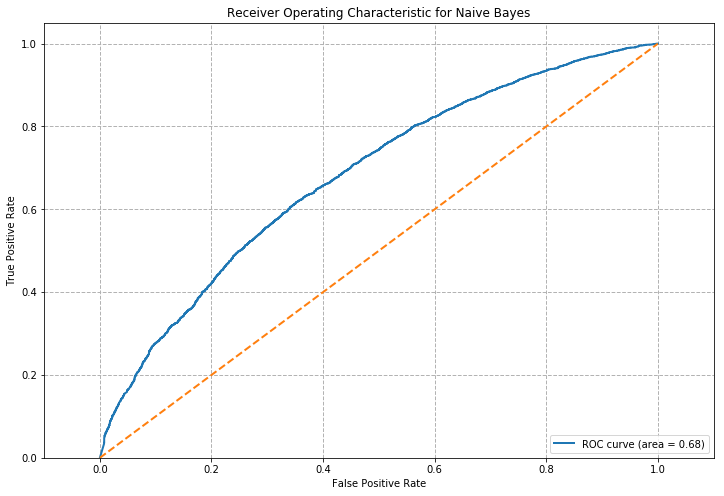

------------------------------------------------------------
Model:  Random Forest

accuracy: 0.647928672393
recall: 0.654804270463
precision: 0.689425478768

Confusion matrix (not normalized): 
[[3312 1746]
 [1492 2647]]

Confusion matrix (normalized): 
[[ 0.65480427  0.34519573]
 [ 0.36047354  0.63952646]]

ROC


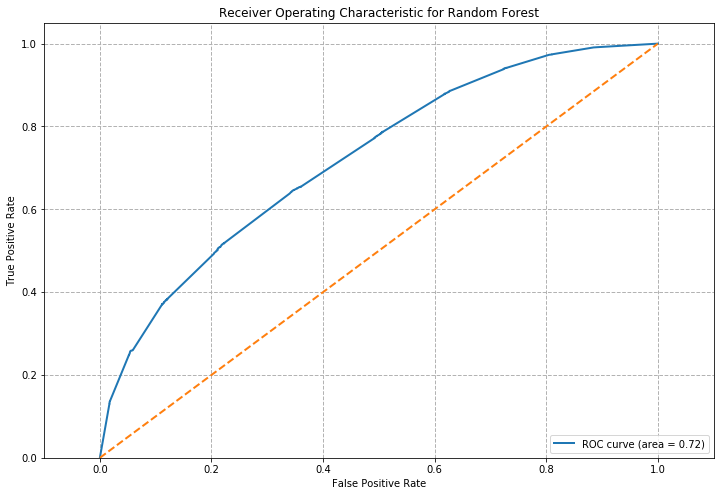

------------------------------------------------------------
Model:  AdaBoost

accuracy: 0.668152658476
recall: 0.800909450376
precision: 0.664534120735

Confusion matrix (not normalized): 
[[4051 1007]
 [2045 2094]]

Confusion matrix (normalized): 
[[ 0.80090945  0.19909055]
 [ 0.4940807   0.5059193 ]]

ROC


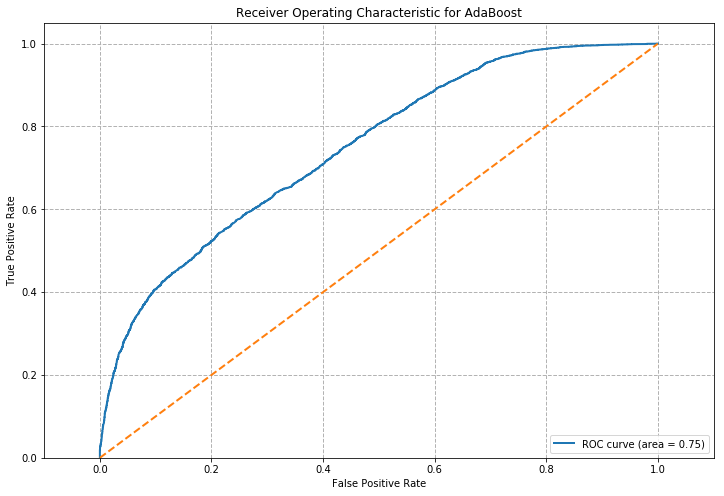

------------------------------------------------------------
Model:  kNN

accuracy: 0.654017614439
recall: 0.719849742981
precision: 0.673510913799

Confusion matrix (not normalized): 
[[3641 1417]
 [1765 2374]]

Confusion matrix (normalized): 
[[ 0.71984974  0.28015026]
 [ 0.42643151  0.57356849]]

ROC


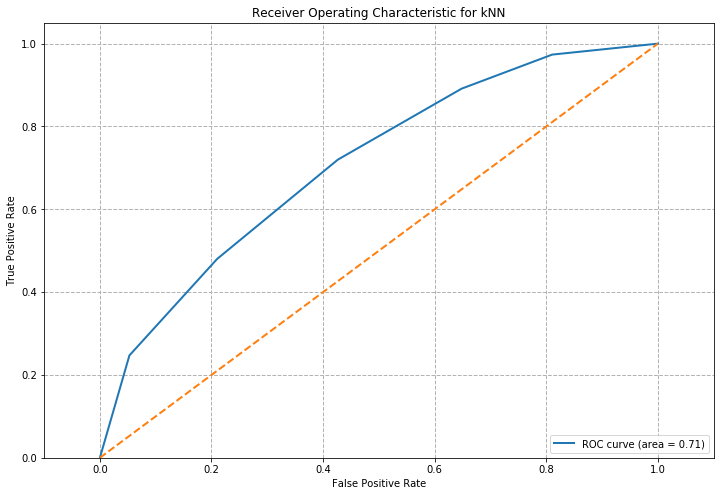

------------------------------------------------------------
Model:  Neural Network with 3 hidden layers

accuracy: 0.658366858758
recall: 0.749703440095
precision: 0.66901905434

Confusion matrix (not normalized): 
[[3792 1266]
 [1876 2263]]

Confusion matrix (normalized): 
[[ 0.74970344  0.25029656]
 [ 0.45324958  0.54675042]]

ROC


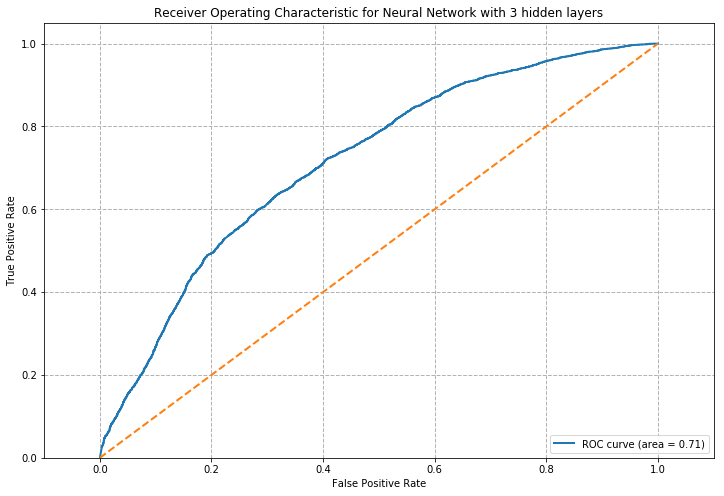

In [14]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import confusion_matrix
import numpy as np

# Classification
models = {
    'Naive Bayes': GaussianNB(),
    'Random Forest': RandomForestClassifier(),
    'AdaBoost': AdaBoostClassifier(),
    'kNN': KNeighborsClassifier(),
    'Neural Network with 3 hidden layers': MLPClassifier((300, 300, 300)),
}
#    'SVM with linear kernel': SVC(kernel='linear'),

for model_name, model in models.items():
    print('-' * 60)
    print('Model: ', model_name)
    
    current_model = model
    current_model.fit(LSI_vectors_train, locs_train)
    locs_predict = current_model.predict(LSI_vectors_test)
    locs_predict_probability = current_model.predict_proba(LSI_vectors_test)  # For ROC curve
    
    # Confusion matrix
    con_matrix = confusion_matrix(locs_test, locs_predict, labels=[1, 0])  # Top-left corner is Class1 - Class1
    normalized_con_matrix = con_matrix.astype('float') / con_matrix.sum(axis=1)[:, np.newaxis]
    
    # ROC curve
    false_positive_rate, true_positive_rate, thresholds = roc_curve(locs_test, locs_predict_probability[:, 1])
    roc_auc = auc(false_positive_rate, true_positive_rate)
    
    print('\naccuracy: ' + str(accuracy_score(locs_test, locs_predict)))
    print('recall: ' + str(recall_score(locs_test, locs_predict)))
    print('precision: ' + str(precision_score(locs_test, locs_predict)))
    
    print('\nConfusion matrix (not normalized): ')
    print(con_matrix)
    print('\nConfusion matrix (normalized): ')
    print(normalized_con_matrix)
    
    print('\nROC')
    plt.figure(figsize=(12, 8))
    plt.plot(false_positive_rate, true_positive_rate, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], lw=2, linestyle='--')
    plt.grid(color='0.7', linestyle='--', linewidth=1)
    plt.xlim([-0.1, 1.1])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for ' + model_name)
    plt.legend(loc="lower right")
    plt.savefig('Figures/q2_ROC_' + model_name + '.png', format='png')
    plt.show()
    

#### 3